  # ДЗ №3. Тематическое моделирование

In [1]:
import nltk
import numpy as np
import pandas as pd
import random
import re
import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
from catboost import CatBoostClassifier
from collections import defaultdict
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

random.seed(123)
np.random.seed(123)

## EDA

Загрузим набор данных и отобразим несколько строк.

In [2]:
_dataset = pd.read_csv('./data/IMDB Dataset.csv')

In [5]:
_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Данные содержат HTML теги от которых хорошо бы избавится.

Объявим класс для предобработки текста.

In [7]:
class Preprocessor():
    '''
    Предобрабатывает документы:
    - удаляет теги HTML;
    - удаляет все символы кроме букв английского алфавита;
    - приводит документы к нижнему регистру.
    '''

    forbidden_chars_regex = re.compile('[^A-Za-z\s]')

    def fit(self, X, y): # для совместимости с sklearn.pipeline.Pipeline, если потребуется
        return self

    def transform(self, X):
        result = []
        for document in tqdm(X):
            soup = BeautifulSoup(document)
            text = soup.get_text(' ') # не просто удалим теги, а заменим их на пробелы для того, что бы строки вида "hello<br/>world" не превратились в "helloworld"
            text = self.forbidden_chars_regex.sub(r'', text)
            result.append(text.lower())

        return result

In [8]:
# обработаем корпус
_X = Preprocessor().transform(_dataset['review'])

# отделим целевую переменную и закодируем ее числовыми значениями
_target = (_dataset['sentiment'] == 'positive').astype(int)

100%|██████████| 50000/50000 [00:08<00:00, 5633.58it/s]


In [9]:
_X[1] # убедимся что html теги были корректно обработаны

'a wonderful little production  the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece  the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life  the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done'

In [10]:
# разделим данные на тренировочный и тестовый набор
_X_train, _X_test, _y_train, _y_test = train_test_split(_X, _target, test_size=0.2, random_state=123)

<Axes: >

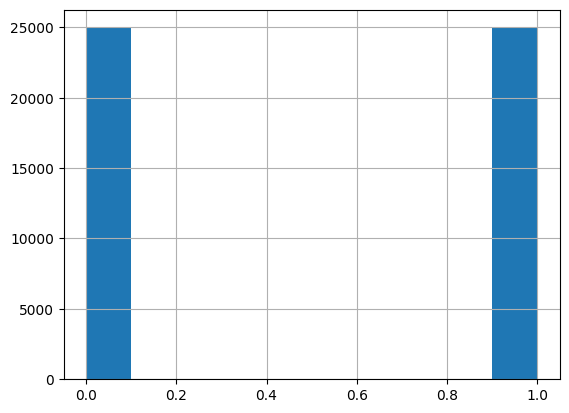

In [11]:
# сбалансированы ли классы?
_target.hist()

## Моделирование

In [12]:
# утилитная функция для печати метрик
def print_score(y_test, y_pred):
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('ROC AUC:', roc_auc_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))

### TF-IDF

Каждый документ кодируется TF-IDF вектором.

In [ ]:
# загрузим список стоп-слов для английского языка
nltk.download('stopwords')
_stop_words = nltk.corpus.stopwords.words('english')

In [14]:
_tfidf_vectorizer = TfidfVectorizer(stop_words=_stop_words,
                                    ngram_range=(1, 2),
                                    max_features=2000,
                                    min_df=1, # лучше всего работает со значением по-умолчанию
                                    max_df=1.0, # Значения < 0.7 ухудшило результат. > 0.7 не повлияло. Оставляем по-умолчанию.
                                    norm=None)
_tfidf_X_train = _tfidf_vectorizer.fit_transform(_X_train)

In [15]:
print(len(_tfidf_vectorizer.get_feature_names_out()))
print(_tfidf_vectorizer.get_feature_names_out()[:50])

2000
['ability' 'able' 'absolute' 'absolutely' 'absurd' 'academy' 'accent'
 'accept' 'accident' 'according' 'accurate' 'across' 'act' 'acted'
 'acting' 'action' 'actions' 'actor' 'actors' 'actress' 'actresses' 'acts'
 'actual' 'actually' 'adaptation' 'add' 'added' 'addition' 'adds' 'admit'
 'adult' 'adults' 'adventure' 'advice' 'affair' 'afraid' 'age' 'agent'
 'ago' 'agree' 'ahead' 'air' 'al' 'alan' 'alien' 'aliens' 'alive' 'allow'
 'allowed' 'almost']


Много бесполезных слов. К сожалению, отсеять их без потери качества не получилось.

In [ ]:
# Этот код использовался для подбора гиперпараметров.
'''
from catboost import cv, Pool

_params = {"iterations": 1000,
           "loss_function": "Logloss",
           "learning_rate": 0.1,
           "depth": 3}

_cv_results = cv(pool=Pool(_tfidf_X_train, label=_y_train),
                 params=_params,
                 nfold=3,
                 partition_random_seed=123,
                 shuffle=True,
                 stratified=True,
                 plot=True,
                 early_stopping_rounds=50)

print(_cv_results)
'''

In [17]:
_y_pred = CatBoostClassifier(iterations=600, learning_rate=0.1, depth=3, random_seed=123, verbose=100) \
    .fit(_tfidf_X_train, _y_train, plot=True, early_stopping_rounds=50) \
    .predict(_tfidf_vectorizer.transform(_X_test))

print_score(_y_test, _y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6733668	total: 242ms	remaining: 2m 25s
100:	learn: 0.4458131	total: 6.7s	remaining: 33.1s
200:	learn: 0.3943169	total: 12.9s	remaining: 25.5s
300:	learn: 0.3645751	total: 18.8s	remaining: 18.6s
400:	learn: 0.3441061	total: 24.7s	remaining: 12.2s
500:	learn: 0.3282755	total: 30.7s	remaining: 6.07s
599:	learn: 0.3155404	total: 36.6s	remaining: 0us
Accuracy: 0.8589
ROC AUC: 0.8587870490035444
F1: 0.8630761766132945
Precision: 0.8415972747918243
Recall: 0.8856801433977295


## Embeddings

Веторизуем корпус используя embeddings.

Скачаем модель word2vec https://code.google.com/archive/p/word2vec/ и поместим ее в директорию data.

In [20]:
_google_news_model = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

Объявим класс векторизатора.

In [18]:
class Word2VecVectorizer():
    '''
    Веторизует каждый документ в данном корпусе следующий образом:
    - получить вектор word2vec для каждого слова документа;
    - найти среднее данных векторов.
    '''

    _vector_size = 300

    def __init__(self, word2vec_model):
        self._word2vec_model = word2vec_model


    def fit(self, X, y): # для совместимости с sklearn.pipeline.Pipeline, если потребуется
        return self


    def transform(self, X):
        result = np.zeros(shape=(len(X), self._vector_size), dtype=np.float32)

        for i, document in tqdm(enumerate(X)):
            words = document.split()
            # вектора всех слов документа
            vectors = np.zeros(shape=(len(words), self._vector_size))

            for j, word in enumerate(words):
                if word in self._word2vec_model: # слово может отсутствовать в модели word2vec
                    vectors[j] = self._word2vec_model[word]

            # находим среднее
            result[i] = np.mean(vectors, axis=0)

        return result

In [21]:
_w2v_vectorizer = Word2VecVectorizer(_google_news_model).fit(_X_train, _y_train)

# векторизуем корпус
_w2v_X_train = _w2v_vectorizer.transform(_X_train)

40000it [00:25, 1543.72it/s]


In [ ]:
# Этот код использовался для подбора гиперпараметров.
'''
_params = {"iterations": 1000,
           "loss_function": "Logloss",
           "learning_rate": 0.1,
           "depth": 3}

_cv_results = cv(pool=Pool(_w2v_X_train, label=_y_train),
                 params=_params,
                 nfold=3,
                 partition_random_seed=123,
                 shuffle=True,
                 stratified=True,
                 plot=True,
                 early_stopping_rounds=50)

print(_cv_results)
'''

In [23]:
_y_pred = CatBoostClassifier(iterations=600, learning_rate=0.1, depth=3, random_seed=123, verbose=100) \
    .fit(_w2v_X_train, _y_train, plot=True, early_stopping_rounds=50) \
    .predict(_w2v_vectorizer.transform(_X_test))

print_score(_y_test, _y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6750329	total: 31.9ms	remaining: 19.1s
100:	learn: 0.4127516	total: 2.46s	remaining: 12.1s
200:	learn: 0.3702524	total: 4.67s	remaining: 9.26s
300:	learn: 0.3470895	total: 6.86s	remaining: 6.82s
400:	learn: 0.3301543	total: 9.01s	remaining: 4.47s
500:	learn: 0.3165111	total: 11.2s	remaining: 2.21s
599:	learn: 0.3047748	total: 13.3s	remaining: 0us


10000it [00:06, 1556.22it/s]

Accuracy: 0.8429
ROC AUC: 0.8428648881366269
F1: 0.8447475046941397
Precision: 0.8383679874460572
Recall: 0.8512248556064529


### Embeddings + IDF

Теперь проделаем тоже самое, но умножим каждый embedding на IDF данного слова.

In [24]:
class Word2VecIdfVectorizer():
    '''
    Веторизует каждый документ в данном корпусе следующий образом:
    - получить вектор word2vec для каждого слова документа;
    - умножить каждый вектор на idf соответстующего слова;
    - найти среднее полученных векторов.
    '''

    _vector_size = 300

    def __init__(self, word2vec_model, tfidf_vectorizer):
        self._word2vec_model = word2vec_model
        self._tfidf_vectorizer = tfidf_vectorizer
        self._idf_weights = None


    def fit(self, X, y):
        idf_list = self._tfidf_vectorizer.idf_
        
        max_idf = max(idf_list) # неизвестным словам присваиваем максимальный IDF

        self._idf_weights = defaultdict(lambda: max_idf)
        for word, idf_index in self._tfidf_vectorizer.vocabulary_.items():
            self._idf_weights[word] = idf_list[idf_index]

        return self


    def transform(self, X):
        result = np.zeros(shape=(len(X), self._vector_size), dtype=np.float32)

        for i, document in tqdm(enumerate(X)):
            words = document.split() # разделяем документ на слова
            vectors = np.zeros(shape=(len(words), self._vector_size))
            for j, word in enumerate(words):
                if word in self._word2vec_model:
                    # получаем embedding для каждого слова и умножаем на IDF
                    vectors[j] = self._word2vec_model[word] * self._idf_weights[word]

            result[i] = np.mean(vectors, axis=0)

        return result

In [25]:
_full_tfidf_vectorizer = TfidfVectorizer(norm=None).fit(_X_train)

In [26]:
_w2vidf_vectorizer = Word2VecIdfVectorizer(_google_news_model, _full_tfidf_vectorizer).fit(_X_train, _y_train)
_w2vidf_X_train = _w2vidf_vectorizer.transform(_X_train)

40000it [00:49, 809.79it/s]


In [ ]:
# Этот код использовался для подбора гиперпараметров.
'''
from catboost import cv, Pool

_params = {"iterations": 1000,
           "loss_function": "Logloss",
           "learning_rate": 0.1,
           "depth": 3}

cv_results = cv(pool=Pool(_w2vidf_X_train, label=_y_train),
                params=_params,
                nfold=2,
                partition_random_seed=123,
                shuffle=True,
                stratified=True,
                plot=True,
                early_stopping_rounds=50)

print(cv_results)
'''

In [28]:
_y_pred = CatBoostClassifier(iterations=700, learning_rate=0.1, depth=3, random_seed=123, verbose=100) \
    .fit(_w2vidf_X_train, _y_train, plot=True, early_stopping_rounds=50) \
    .predict(_w2vidf_vectorizer.transform(_X_test))

print_score(_y_test, _y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6786261	total: 27.4ms	remaining: 19.1s
100:	learn: 0.4370345	total: 2.5s	remaining: 14.8s
200:	learn: 0.3960172	total: 4.8s	remaining: 11.9s
300:	learn: 0.3727666	total: 7.17s	remaining: 9.51s
400:	learn: 0.3557347	total: 9.52s	remaining: 7.1s
500:	learn: 0.3417560	total: 11.8s	remaining: 4.67s
600:	learn: 0.3295110	total: 14s	remaining: 2.3s
699:	learn: 0.3187859	total: 16.2s	remaining: 0us


10000it [00:11, 842.44it/s]

Accuracy: 0.8317
ROC AUC: 0.8316655305799596
F1: 0.8336463378471879
Precision: 0.8275117739403454
Recall: 0.8398725353515236


## Выводы:

1. TF-IDF и embeddings дают сравнимое качество, однако word2vec работает с векторами намного меньшего размера => модель обучается быстрее.<br>
2. Embeddings лучше подходят по следующей причине (предположение). TF-IDF максимален для слов специфичных для данного документа. Это хорошо для задач вида "найти документ, похожий на данный". Однако наша цель - классификация документов на ДВА класса (хорошо сбалансированных). Таким образом слова, специфичные для данной категории, могут иметь низкий TF-IDF потому что они употребляются во многих документах корпуса. С другой стороны, слова, специфичные для товара, на который оставляют отзыв могут иметь достаточно высокий TF-IDF. Особенно, если отзывы на данный товар занимают небольшой процент в корпусе.
3. embeddings + TF-IDF показал чуть худший результат. Возможно TF-IDF вообше не очень подходит для данной задачи (см. пункт 2).